# Effect inference with timeseries data

In this notebook, we will look at an example of causal effect inference from timeseries data. We will use DoWhy's functionality to add temporal dependencies to a causal graph and estimate causal effect based on the augmented graph.  

In [1]:
import networkx as nx
import pandas as pd
from dowhy.utils.timeseries import create_graph_from_csv,create_graph_from_user
from dowhy.utils.plotting import plot, pretty_print_graph

## Loading timeseries data and causal graph

In [2]:
# read the dataframe in a csv format from the user
dataset_path="../datasets/temporal_dataset.csv"
dataframe=pd.read_csv(dataset_path)

In temporal causal inference, accurately estimating causal effects often requires accounting for time lags between nodes in a graph. For instance, if $node_1$ influences $node_2$ with a time lag of 5 timestamps, we represent this dependency as $node_1(t-5)$ -> $node_2(t)$.

We can provide the causal graph as a networkx DAG or as a dot file. The edge attributes should mention the maximum `time_lag` that is associated with each edge (if any).

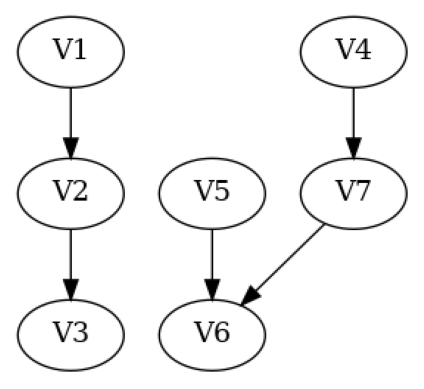

In [3]:
from dowhy.utils.timeseries import create_graph_from_dot_format

file_path = "../datasets/temporal_graph.dot"

graph = create_graph_from_dot_format(file_path)
plot(graph)


We can also create a csv file with the edges in the temporal graph. The columns in the csv are node1, node2, time_lag which represents an directed edge node1 -> node2 with the time lag of time_lag. Let us consider the following graph as the input:

| node1  | node2  | time_lag |
|--------|--------|----------|
| V1     | V2     | 3        |
| V2     | V3     | 4        |
| V5     | V6     | 1        |
| V4     | V7     | 4        |
| V7     | V6     | 3        |

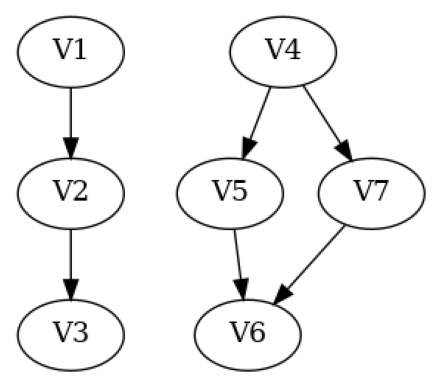

In [4]:
# Input a csv file with the edges in the graph with the columns: node_1,node_2,time_lag
file_path = "../datasets/temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
plot(graph)

## Dataset Shifting and Filtering

To prepare the dataset for temporal causal inference, we need to shift the columns by the given time lag.

For example, in the causal graph above, $node_1(t-3)$ -> $node_2(t)$ with a lag of 3. When considering $node_2$ as the target node, the data for $node_1$ should be shifted down by 3 timestamps. This adjustment ensures that the edge $node_1$ -> $node_2$ accurately represents the lagged dependency. Shifting the data in this manner creates additional columns and allows downstream estimators to acccess the correct values in the same row of a dataframe. 

In [5]:
from dowhy.timeseries.temporal_shift import find_lagged_parents,shift_columns_by_lag, find_ancestors

In [6]:
# the outcome node for which effect estimation has to be done, node:6
target_node = 'V6'

# find the action nodes of the given target node with respective lag times
parents, time_lags = find_lagged_parents(graph, target_node)
ancestors = find_ancestors(graph, target_node)
print ("Parents of the target node with respective time lags: ", parents, time_lags)
print ("Ancestors of the target node: ", ancestors)

Parents of the target node with respective time lags:  ['V5', 'V7'] [(1,), (3, 5)]
Ancestors of the target node:  ['V4']


In [7]:
time_lags

In [8]:
time_shifted_df = shift_columns_by_lag(dataframe,parents,time_lags,ancestors,filter=True, child_node=target_node)
time_shifted_df.head()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

## Causal Effect Estimation

Once you have the new dataframe, causal effect estimation can be performed on the target node with respect to the action nodes.

In [ ]:
# inlcude specific treatments
treatment = 'V5'
treatment_columns = [treatment] + [f"{treatment}_lag{i}" for i in range(1, int(time_lags[parents.index(treatment)] + 1) ) ]
treatment_columns

['V5', 'V5_lag1']

In [ ]:
# include all the treatments
treatment_columns = list(time_shifted_df.columns)
treatment_columns.remove(target_node)
treatment_columns

['V5', 'V7', 'V5_lag1', 'V7_lag1', 'V7_lag2', 'V7_lag3', 'V4']

In [ ]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

model = CausalModel(
    data=time_shifted_df,
    treatment=treatment_columns,
    outcome=target_node,
    graph=graph
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)

common_causes = model._common_causes
# estimate v5t effect on v6t

print(estimate)

/home/t-ashutoshs/home/dowhy/dowhy/causal_model.py:583: UserWarning: 3 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


NetworkXError: The node V5_lag1 is not in the digraph.

# Importing temporal causal graph from Tigramite library

Tigramite is a popular temporal causal discovery library. In this section, we highlight how the causal graph can be obtained by applying PCMCI+ algorithm from tigramite and imported into DoWhy.

In [ ]:
import tigramite
from tigramite import data_processing
import matplotlib.pyplot as plt
import pandas as pd

dataframe = dataframe.astype(float)
var_names = dataframe.columns
# convert the dataframe values to float
dataframe = tigramite.data_processing.DataFrame(dataframe.values, var_names=var_names)

In [ ]:
from tigramite import plotting as tp
tp.plot_timeseries(dataframe, figsize=(15, 5)); plt.show()

In [ ]:
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import numpy as np
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [ ]:
correlations = pcmci.run_bivci(tau_max=3, val_only=True)['val_matrix']
matrix_lags = np.argmax(np.abs(correlations), axis=2)

In [ ]:
tau_max = 3
pc_alpha = None
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)

In [ ]:
from dowhy.utils.timeseries import create_graph_from_networkx_array

graph = create_graph_from_networkx_array(results['graph'], var_names)

plot(graph)